# (2)Roeスキームを使って解く

参考：Pythonで学ぶ流体力学の数値計算法


In [117]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


In [118]:
nmax = 300
jmax = 101
dt = 0.002
gamma = 1.4

In [119]:
DIM = 3
# 左
p1 = 1.0
rho1 = 1.0
u1 = 0.0
# 右
p2 = 0.1
rho2 = 0.125
u2 = 0.0

In [120]:
xmin, xmax = -1.0, 1.0
xmid = 0.0
x = np.linspace(xmin, xmax, jmax)
dx = np.mean(np.diff(x))
dtdx = dt / dx

In [121]:
# 状態方程式
def eq_energy(p, rho, u):
    return p / (gamma - 1.0) + (1 / 2) * rho * u**2

def eq_pressure(e, rho, u):
    return (gamma - 1.0) * (e - 0.5 * rho * u**2)

In [122]:
# Roe平均
def calc_roe_ave(rhoL, rhoR, xL, xR):
    """xL, xR: 平均を取る物性値"""
    w1 = np.sqrt(rhoL)
    w2 = np.sqrt(rhoR)
    a = w1 * xL + w2 * xR
    b = w1 + w2
    return a / b

In [123]:
# 初期化
def init_Q():
    Q = np.zeros((jmax, DIM))
    assert len(x) == len(Q)
    Q[x <= xmid, 0] = rho1
    Q[x <= xmid, 1] = rho1 * u1
    Q[x <= xmid, 2] = eq_energy(p=p1, rho=rho1, u=u1)
    Q[x > xmid, 0] = rho2
    Q[x > xmid, 1] = rho2 * u2
    Q[x > xmid, 2] = eq_energy(p=p2, rho=rho2, u=u2)
    return Q

In [124]:
def calc_CFL(Q: np.ndarray):
    all_rho, all_rhou, all_e = Q[:, 0], Q[:, 1], Q[:, 2]
    all_u = all_rhou / all_rho
    all_p = eq_pressure(e=all_e, rho=all_rho, u=all_u)
    all_c = np.sqrt(gamma * all_p / all_rho)
    speed = all_c + np.abs(all_u)
    return np.max(speed) * dtdx

In [125]:
def Roe_flux(QL, QR, E):
    for j in range(jmax - 1):
        rhoL, uL, pL = QL[j, 0], QL[j, 1], QL[j, 2]
        rhoR, uR, pR = QR[j+1, 0], QR[j+1, 1], QL[j+1, 2]

        rhouL = rhoL * uL
        rhouR = rhoR * uR
        eL = eq_energy(p=pL, rho=rhoL, u=uL)
        eR = eq_energy(p=pR, rho=rhoR, u=uR)
        # エンタルピー
        HL = (eL + pL) / rhoL
        HR = (eR + pR) / rhoR
        # 平均
        rho_ave = np.sqrt(rhoL * rhoR)
        u_ave = calc_roe_ave(rhoL=rhoL, rhoR=rhoR, xL=uL, xR=uR)
        H_ave = calc_roe_ave(rhoL=rhoL, rhoR=rhoR, xL=HL, xR=HR)
        c_ave = np.sqrt((gamma - 1.0) * (H_ave - 0.5 * u_ave**2))

        dQ = np.zeros(DIM)
        dQ[0] = rhoR - rhoL
        dQ[1] = rhouR - rhouL
        dQ[2] = eR - eL

        _lambda = np.diag([
            np.abs(u_ave - c_ave),
            np.abs(u_ave),
            np.abs(u_ave + c_ave)
        ])

        b1 = 0.5 * (gamma - 1.0) * u_ave ** 2 / c_ave ** 2
        b2 = (gamma - 1.0) / c_ave ** 2

        R = np.zeros((DIM, DIM))
        R[0] = np.ones(DIM)
        R[1] = np.array([u_ave - c_ave, u_ave, u_ave + c_ave])
        R[2, 0] = H_ave - u_ave * c_ave
        R[2, 1] = 0.5 * u_ave**2
        R[2, 2] = H_ave + u_ave * c_ave

        invR = np.zeros((DIM, DIM))
        invR[0, 0] = 0.5 * (b1 + u_ave/c_ave)
        invR[0, 1] = -0.5 * (b2 * u_ave + 1 / c_ave)
        invR[0, 2] = 0.5 * b2
        invR[1, 0] = 1 - b2
        invR[1, 1] = b2 * u_ave
        invR[1, 2] = - b2
        invR[2, 0] = 0.5 * (b1 - u_ave / c_ave)
        invR[2, 1] = 0.5 * (1 / c_ave - b2*u_ave)
        invR[2, 2] = 0.5 * b2

        AQ = R @ _lambda @ invR @ dQ

        EL = np.array([rhouL, pL + rhouL * uL, (eL + pL) * uL])
        ER = np.array([rhouR, pR + rhouR * uR, (eR + pR) * uR])

        E[j] = 0.5 * (ER + EL - AQ)
        

In [126]:
def minmod(x, y):
    sign = np.sign(y)
    t1 = np.minimum(np.abs(x), sign * y)
    t2 = np.maximum(t1, 0.0)
    return sign * t2

In [127]:
def MUSCL(Q, order, kappa):
    rho, rhou, e = Q[:, 0], Q[:, 1], Q[:, 2]
    u = rhou / rho
    _Q = np.zeros_like(Q)
    _Q[:, 0] = rho
    _Q[:, 1] = u
    _Q[:, 2] = eq_pressure(e=e, rho=rho, u=u)

    if order == 2 or order == 3:
        dQ = np.zeros([jmax, DIM])
        for j in range(jmax - 1):
            dQ[j] = _Q[j+1] - _Q[j]
            b = (3.0 - kappa) / (1.0 - kappa)

        Dp = np.zeros([jmax, DIM])
        Dm = np.zeros([jmax, DIM])

        for j in range(1, jmax - 1):
            Dp[j] = minmod(x=dQ[j], y=b*dQ[j-1])
            Dm[j] = minmod(x=dQ[j-1], y=b*dQ[j])
        Dp[0] = Dp[1]
        Dm[0] = Dm[1]

        QL = _Q.copy()
        QR = _Q.copy()
        for j in range(1, jmax - 1):
            QL[j] += 0.25 * ((1 - kappa) * Dp[j] + (1.0 + kappa) * Dm[j])
            QR[j] -= 0.25 * ((1 + kappa) * Dp[j] + (1.0 - kappa) * Dm[j])

    else:
        QL = _Q.copy()
        QR = _Q.copy()

    return QL, QR

In [128]:
def Roe_FDS(Q, order, kappa, nmax):
    E = np.zeros([jmax, 3])
    store_Q = np.zeros((nmax, jmax, DIM))

    for n in range(nmax):
        Qold = Q.copy()
        
        coefs = [0.5, 1.0]
        for coef in coefs:
            QL, QR = MUSCL(Qold, order, kappa)
        
            Roe_flux(QL, QR, E)
            for j in range(1, jmax - 1):
                Qold[j] = Q[j] - coef * dtdx * (E[j] - E[j-1])
            
            Qold[0] = Q[0]
            Qold[-1] = Q[-1]
    
        Q[:] = Qold[:]
    
        store_Q[n] = Q
    return store_Q

In [129]:
Q = init_Q()
store_Q = Roe_FDS(Q, order=0, kappa=2, nmax=nmax)
df = pd.DataFrame(store_Q[-1], columns=["Rho", "RhoU", "P"])
df.to_csv("data/df_scheme2.csv")

In [130]:
# グラフの設定
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["figure.dpi"] = 100
plt.rcParams["font.size"] = 10

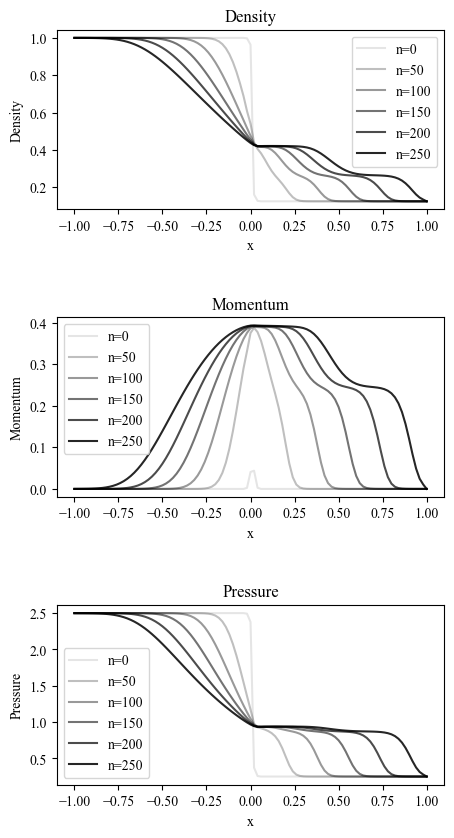

In [131]:
fig = plt.figure(figsize=(5, 10))
plt.subplots_adjust(wspace=0.4, hspace=.6)
axs = [fig.add_subplot(3, 1, i+1) for i in range(DIM)]

name_list = ["Density", "Momentum", "Pressure"]
for i, ax in enumerate(axs):
    ax.set_ylabel(name_list[i])
    ax.set_xlabel("x")
    ax.set_title(name_list[i])
    for n in range(nmax):
        interval = 50
        if n%interval != 0:
            continue
        b = 0.1
        a = (1 - b) / nmax
        alpha = a * n + b
        ax.plot(x, store_Q[n, :, i], color="black", alpha=alpha, label="n={0}".format(n))
    ax.legend()

fig.savefig("img/report2/general_result.png")

# 工夫した点

- 定数と変数を明確に分離
- 変数に上書きして書き換えることはせずに新しく変数を生成
- 複雑な計算（ミスが起こりやすい計算）は関数にくくり出す